In [1]:
import pandas as pd       
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D


import cv2
import warnings
warnings.filterwarnings('ignore')

import random
import os
import glob
from numpy.random import seed



seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from tensorflow.random import set_seed
set_seed(42)


2022-11-29 15:17:26.323573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
main_path = "chest_xray_images/chest_xray/"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

In [3]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]



test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]


val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns = ['class'])
df_val['image'] = [x for x in val_list]

In [4]:
df_train

,class,image
0,Normal,chest_xray_images/chest_xray/train/NORMAL/NORM...
1,Normal,chest_xray_images/chest_xray/train/NORMAL/NORM...
2,Normal,chest_xray_images/chest_xray/train/NORMAL/IM-0...
3,Normal,chest_xray_images/chest_xray/train/NORMAL/NORM...
4,Normal,chest_xray_images/chest_xray/train/NORMAL/IM-0...
...,...,...
5211,Pneumonia,chest_xray_images/chest_xray/train/PNEUMONIA/p...
5212,Pneumonia,chest_xray_images/chest_xray/train/PNEUMONIA/p...
5213,Pneumonia,chest_xray_images/chest_xray/train/PNEUMONIA/p...
5214,Pneumonia,chest_xray_images/chest_xray/train/PNEUMONIA/p...


In [5]:
df_test

,class,image
0,Normal,chest_xray_images/chest_xray/test/NORMAL/IM-00...
1,Normal,chest_xray_images/chest_xray/test/NORMAL/IM-00...
2,Normal,chest_xray_images/chest_xray/test/NORMAL/NORMA...
3,Normal,chest_xray_images/chest_xray/test/NORMAL/NORMA...
4,Normal,chest_xray_images/chest_xray/test/NORMAL/NORMA...
...,...,...
619,Pneumonia,chest_xray_images/chest_xray/test/PNEUMONIA/pe...
620,Pneumonia,chest_xray_images/chest_xray/test/PNEUMONIA/pe...
621,Pneumonia,chest_xray_images/chest_xray/test/PNEUMONIA/pe...
622,Pneumonia,chest_xray_images/chest_xray/test/PNEUMONIA/pe...


In [6]:
df_val

,class,image
0,Normal,chest_xray_images/chest_xray/val/NORMAL/NORMAL...
1,Normal,chest_xray_images/chest_xray/val/NORMAL/NORMAL...
2,Normal,chest_xray_images/chest_xray/val/NORMAL/NORMAL...
3,Normal,chest_xray_images/chest_xray/val/NORMAL/NORMAL...
4,Normal,chest_xray_images/chest_xray/val/NORMAL/NORMAL...
5,Normal,chest_xray_images/chest_xray/val/NORMAL/NORMAL...
6,Normal,chest_xray_images/chest_xray/val/NORMAL/NORMAL...
7,Normal,chest_xray_images/chest_xray/val/NORMAL/NORMAL...
8,Pneumonia,chest_xray_images/chest_xray/val/PNEUMONIA/per...
9,Pneumonia,chest_xray_images/chest_xray/val/PNEUMONIA/per...


## Data Augmentation

Keras ImageDataGenerator is used for getting the input of the original data and further, it makes the transformation of this data on a random basis and gives the output resultant containing only the data that is newly transformed. It does not add the data. Keras image data generator class is also used to carry out data augmentation where we aim to gain the overall increment in the generalization of the model. Operations such as rotations, translations, shearin, scale changes, and horizontal flips are carried out randomly in data augmentation using an image data generator.

In [53]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'image',
    y_col = 'class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col = 'image',
    y_col = 'class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    shuffle = False)

val_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col = 'image',
    y_col = 'class',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary')

Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


In [54]:
# let's build the CNN model

cnn = Sequential()

#Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))

#Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn.add(Conv2D(64, (3, 3), activation="relu"))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer

cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(10))

# Compile the Neural network
cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

2022-11-29 15:53:32.879461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 64)                8

In [56]:
cnn_model = cnn.fit_generator(train_generator,
                              steps_per_epoch = 163,
                              epochs = 25,
                              validation_data = val_generator)

Epoch 1/25
163/163 [==============================] - 67s 405ms/step - loss: 0.3914 - accuracy: 0.8376 - val_loss: 0.5566 - val_accuracy: 0.7500
Epoch 2/25
163/163 [==============================] - 65s 396ms/step - loss: 0.2339 - accuracy: 0.9045 - val_loss: 0.9775 - val_accuracy: 0.5625
Epoch 3/25
163/163 [==============================] - 64s 390ms/step - loss: 0.2113 - accuracy: 0.9158 - val_loss: 0.2557 - val_accuracy: 0.8750
Epoch 4/25
163/163 [==============================] - 64s 394ms/step - loss: 0.1928 - accuracy: 0.9283 - val_loss: 0.2955 - val_accuracy: 0.8125
Epoch 5/25
163/163 [==============================] - 65s 396ms/step - loss: 0.1635 - accuracy: 0.9329 - val_loss: 0.5249 - val_accuracy: 0.6875
Epoch 6/25
163/163 [==============================] - 65s 400ms/step - loss: 0.1710 - accuracy: 0.9344 - val_loss: 0.3736 - val_accuracy: 0.7500
Epoch 7/25
163/163 [==============================] - 64s 395ms/step - loss: 0.1550 - accuracy: 0.9400 - val_loss: 0.3876 - val_ac

## Visualizing model performance

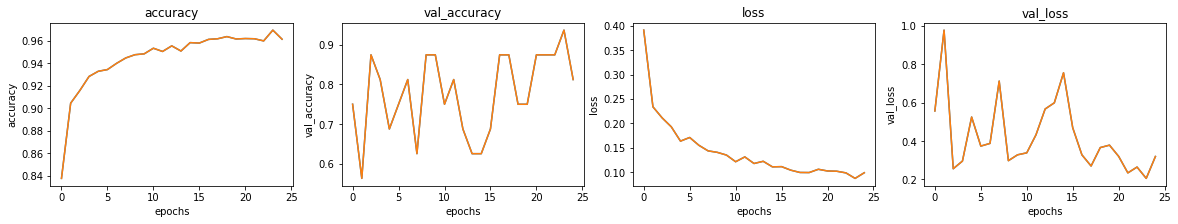

In [57]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, x in enumerate(['accuracy', 'val_accuracy', 'loss', 'val_loss']):
    ax[i].plot(cnn_model.history[x])
    ax[i].plot(cnn_model.history[x])
    ax[i].set_title(x)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(x)

In [72]:
test_accuracy = cnn.evaluate_generator(test_generator)
test_accuracy

[0.3278502821922302, 0.8910256624221802]

In [73]:
print('The testing accuracy is :',test_accuracy[1]*100, '%')

The testing accuracy is : 89.10256624221802 %


In [74]:
val_accuracy = cnn.evaluate_generator(val_generator)
val_accuracy

[0.3193802833557129, 0.8125]

In [75]:
print('The testing accuracy is :',val_accuracy[1]*100, '%')

The testing accuracy is : 81.25 %


In [76]:
df_train['class'].value_counts()

Pneumonia    3875
Normal       1341
Name: class, dtype: int64

In [77]:
df_test['class'].value_counts()

Pneumonia    390
Normal       234
Name: class, dtype: int64

In [78]:
df_val['class'].value_counts()

Normal       8
Pneumonia    8
Name: class, dtype: int64

## SVM

In [35]:
def create_data(data):
    data_set = data['image']
    mydata = []   
    for i in range (0, data_set.size):
        img = cv2.imread(data_set[i], 0)
        img_resized = cv2.resize(img, (50,50))
        image = np.array(img_resized).flatten() 
        
        mydata.append(image)
    return mydata
        



In [36]:
xtrain = create_data(df_train)

In [37]:
len(xtrain)

5216

In [38]:
ytrain = np.array(df_train['class'])

In [39]:
ytrain

array(['Normal', 'Normal', 'Normal', ..., 'Pneumonia', 'Pneumonia',
       'Pneumonia'], dtype=object)

In [40]:
from sklearn import svm
svmClassifier = svm.SVC()
svmClassifier.fit(xtrain, ytrain)

SVC()

In [43]:
xtest = create_data(df_test)
ytest = np.array(df_test['class'])

In [44]:
prediction = svmClassifier.predict(xtest)

In [45]:
accuracy = svmClassifier.score(xtest, ytest)

In [46]:
accuracy

0.7644230769230769

Confusion matrix:
[[ 92 142]
 [  5 385]]


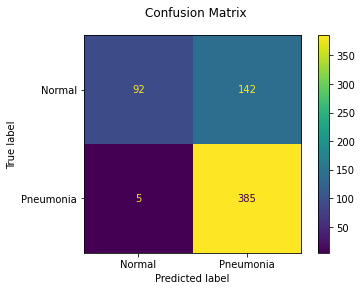

In [47]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, prediction)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

In [51]:
print(
    f"Classification report for classifier {svmClassifier}:\n"
    f"{metrics.classification_report(ytest, prediction)}\n"
)

Classification report for classifier SVC():
              precision    recall  f1-score   support

      Normal       0.95      0.39      0.56       234
   Pneumonia       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.84      0.69      0.70       624
weighted avg       0.81      0.76      0.73       624


